# COMPUTER VISION 1 - TRABAJO PRACTICO nº2

**Autor: Julio Agustín Donadello**

**Fecha de entrega: 22-07-2024**

Fuente: "Image Sharpness Measure for Blurred Images in Frequency Domain" by Kanjar De and V. Masilamani.

In [1]:
import cv as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def mostrar_imagen(imagen, titulo=''):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv.cvtColor(imagen, cv.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

## 1. Implementar la métrica "Image Quality Measure (FM)"

### 1.1 Medición sobre todo el frame

- Implementacion del algoritmo propuesto

In [3]:
def calculate_sharpness(image):
    # Paso 1: Transformada de Fourier
    F = np.fft.fft2(image)
    
    # Paso 2: Shift al centro
    Fc = np.fft.fftshift(F)
    
    # Paso 3: Calculo AF (me quedo con el modul0, ignoro la fase de la transformada)
    AF = np.abs(Fc)
    
    # Paso 4: Valor máximo de componente frecuencial
    M = np.max(AF)
    
    # Paso 5: Cuento componentes de alta frecuencia que no se filtran con el threshold
    thres = M / 1000
    TH = np.sum(AF > thres)
    
    # Paso 6: Calcular la medida de calidad de imagen
    FM = TH / (image.shape[0] * image.shape[1])
    
    return FM

In [4]:
video_path = 'data/focus_video.mov'

- Computo sobre el video

In [5]:
# Cargar el video
cap = cv.VideoCapture(video_path)

sharpness_values = []

while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convertir a escala de grises
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Calcular la nitidez
    sharpness = calculate_sharpness(gray)
    sharpness_values.append(sharpness)
    #print(f'Frame Sharpness: {sharpness}')

cap.release()
cv.destroyAllWindows()

#### Gráfico

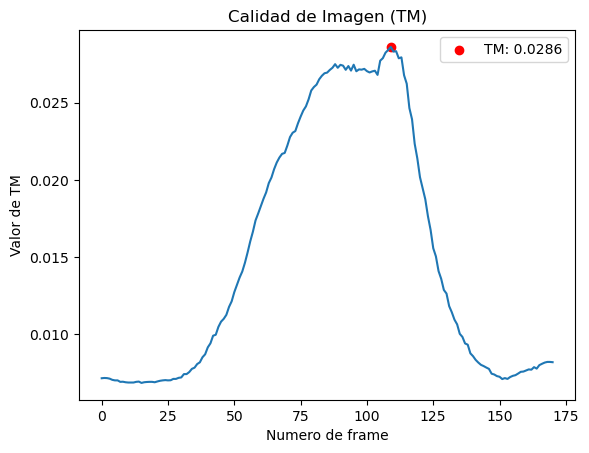

In [6]:
# Mostrar los resultados
max_value = max(sharpness_values)
max_index = sharpness_values.index(max_value)
plt.plot(sharpness_values)
plt.scatter([max_index], [max_value], color='red', label=f'TM: {max_value:.4f}') 
plt.title(f"Calidad de Imagen (TM)")
plt.xlabel("Numero de frame")
plt.ylabel("Valor de TM")
plt.legend()
plt.show()

### 1.2 Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame

In [7]:
def get_center_roi(image, roi_ratio):
    height, width = image.shape
    roi_area = roi_ratio * width * height
    roi_side = int(np.sqrt(roi_area))
    x_start = width // 2 - roi_side // 2
    y_start = height // 2 - roi_side // 2
    return image[y_start:y_start+roi_side, x_start:x_start+roi_side]

In [8]:
#ratio = 0.1
ratio = 0.05
sharpness_values_roi = []

cap = cv.VideoCapture(video_path)

while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convertir a escala de grises
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # Obtener la region de interes central
    roi = get_center_roi(gray, roi_ratio=ratio)
    
    # Calcular la nitidez
    sharpness_roi = calculate_sharpness(roi)
    sharpness_values_roi.append(sharpness_roi)
    #print(f'Frame Sharpness: {sharpness}')

#### Gráfico

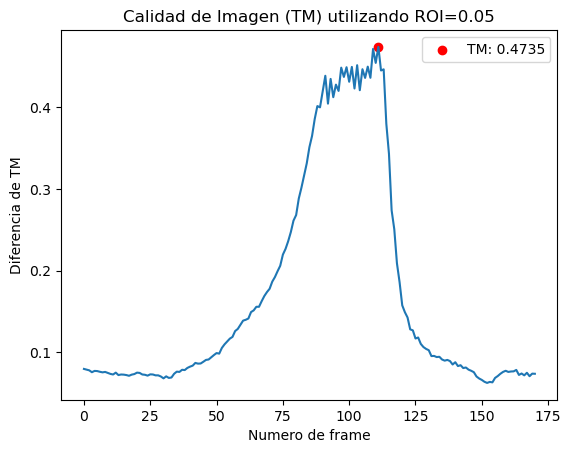

In [9]:

cap.release()
cv.destroyAllWindows()

# Mostrar los resultados
max_value = max(sharpness_values_roi)
max_index = sharpness_values_roi.index(max_value)
plt.plot(sharpness_values_roi)
plt.scatter([max_index], [max_value], color='red', label=f'TM: {max_value:.4f}') 
plt.title(f"Calidad de Imagen (TM) utilizando ROI={ratio}")
plt.xlabel("Numero de frame")
plt.ylabel("Diferencia de TM")
plt.legend()
plt.show()

Con ratio = 0.1 obtenemos el valor maximo de la metrica en 0.34 aproximadamente mientras que con ratio = 0.05 obtenemos 0.47 en esta misma condicion.

#### Mejora en la metrica

Text(0, 0.5, 'Diferencia de TM')

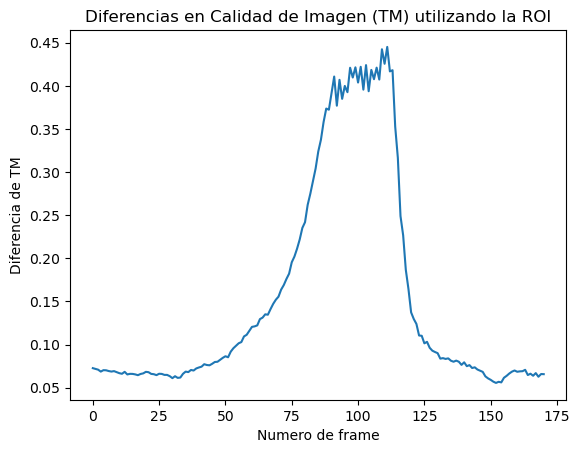

In [10]:
dif_list = []
for i in range(len(sharpness_values_roi)):
    dif = sharpness_values_roi[i] - sharpness_values[i]
    dif_list.append(dif)
dif_list

plt.plot(dif_list)
plt.title("Diferencias en Calidad de Imagen (TM) utilizando la ROI")
plt.xlabel("Numero de frame")
plt.ylabel("Diferencia de TM")

Se nota una gran diferencia de valores de TM en los frames cuando el video "hace foco" al trabajar con el area de interes en la region central de la imagen respecto de trabajar con todo el frame. 

Por otro lado, se observa la aparicion de ruido en estos frames particularmente, el cual no estaba presenta cuando se calculaba la metrica sobre todo el frame o no se llegaba a visualizar al no estar amplificado.

#### Video

In [32]:
def get_center_roi_coord(image, roi_ratio):
    height, width = image.shape
    roi_area = roi_ratio * width * height
    roi_side = int(np.sqrt(roi_area))
    x_start = width // 2 - roi_side // 2
    y_start = height // 2 - roi_side // 2
    return y_start, y_start + roi_side, x_start, x_start + roi_side

output_path = 'output/ROI.avi'

# Definir el umbral de nitidez
sharpness_threshold = 0.3  # ajustado según el grafico anterior
ratio = 0.1  # Proporción de la ROI

# Abrir el video
cap = cv.VideoCapture(video_path)
fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter(output_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convertir a escala de grises
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Obtener la region de interes central
    y_start, y_end, x_start, x_end = get_center_roi_coord(gray, ratio)
    roi = gray[y_start:y_end, x_start:x_end]
    
    # Calcular la nitidez
    sharpness = calculate_sharpness(roi)
    
    # Determinar el color del rectángulo (rojo para desenfocado, verde para enfocado)
    color = (0, 255, 0) if sharpness >= sharpness_threshold else (0, 0, 255)
    
    # Dibujar el rectángulo sobre la ROI
    cv.rectangle(frame, (x_start, y_start), (x_end, y_end), color, 2)
    
    # Escribir el frame procesado en el video de salida
    out.write(frame)
    
    # Mostrar el frame con el rectángulo superpuesto (opcional)
    # cv.imshow('Frame', frame)
    # if cv.waitKey(1) & 0xFF == ord('q'):
    #    break

cap.release()
out.release()
cv.destroyAllWindows()


### 1.3 Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. 

N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc

In [42]:
def get_grid_regions(roi, N, M, equispace):
    roi_height, roi_width = roi.shape
    region_height = (roi_height - (N - 1) * equispace) // N
    region_width = (roi_width - (M - 1) * equispace) // M
    regions = []
    
    for i in range(N):
        row_regions = []
        for j in range(M):
            y_start = i * (region_height + equispace)
            x_start = j * (region_width + equispace)
            y_end = y_start + region_height
            x_end = x_start + region_width
            # Asegurarse de que la región está dentro de los límites
            if y_end <= roi_height and x_end <= roi_width:
                region = roi[y_start:y_end, x_start:x_end]
                row_regions.append((region, (x_start, y_start, x_end, y_end)))
        regions.append(row_regions)
    
    return regions

#### Gráfico

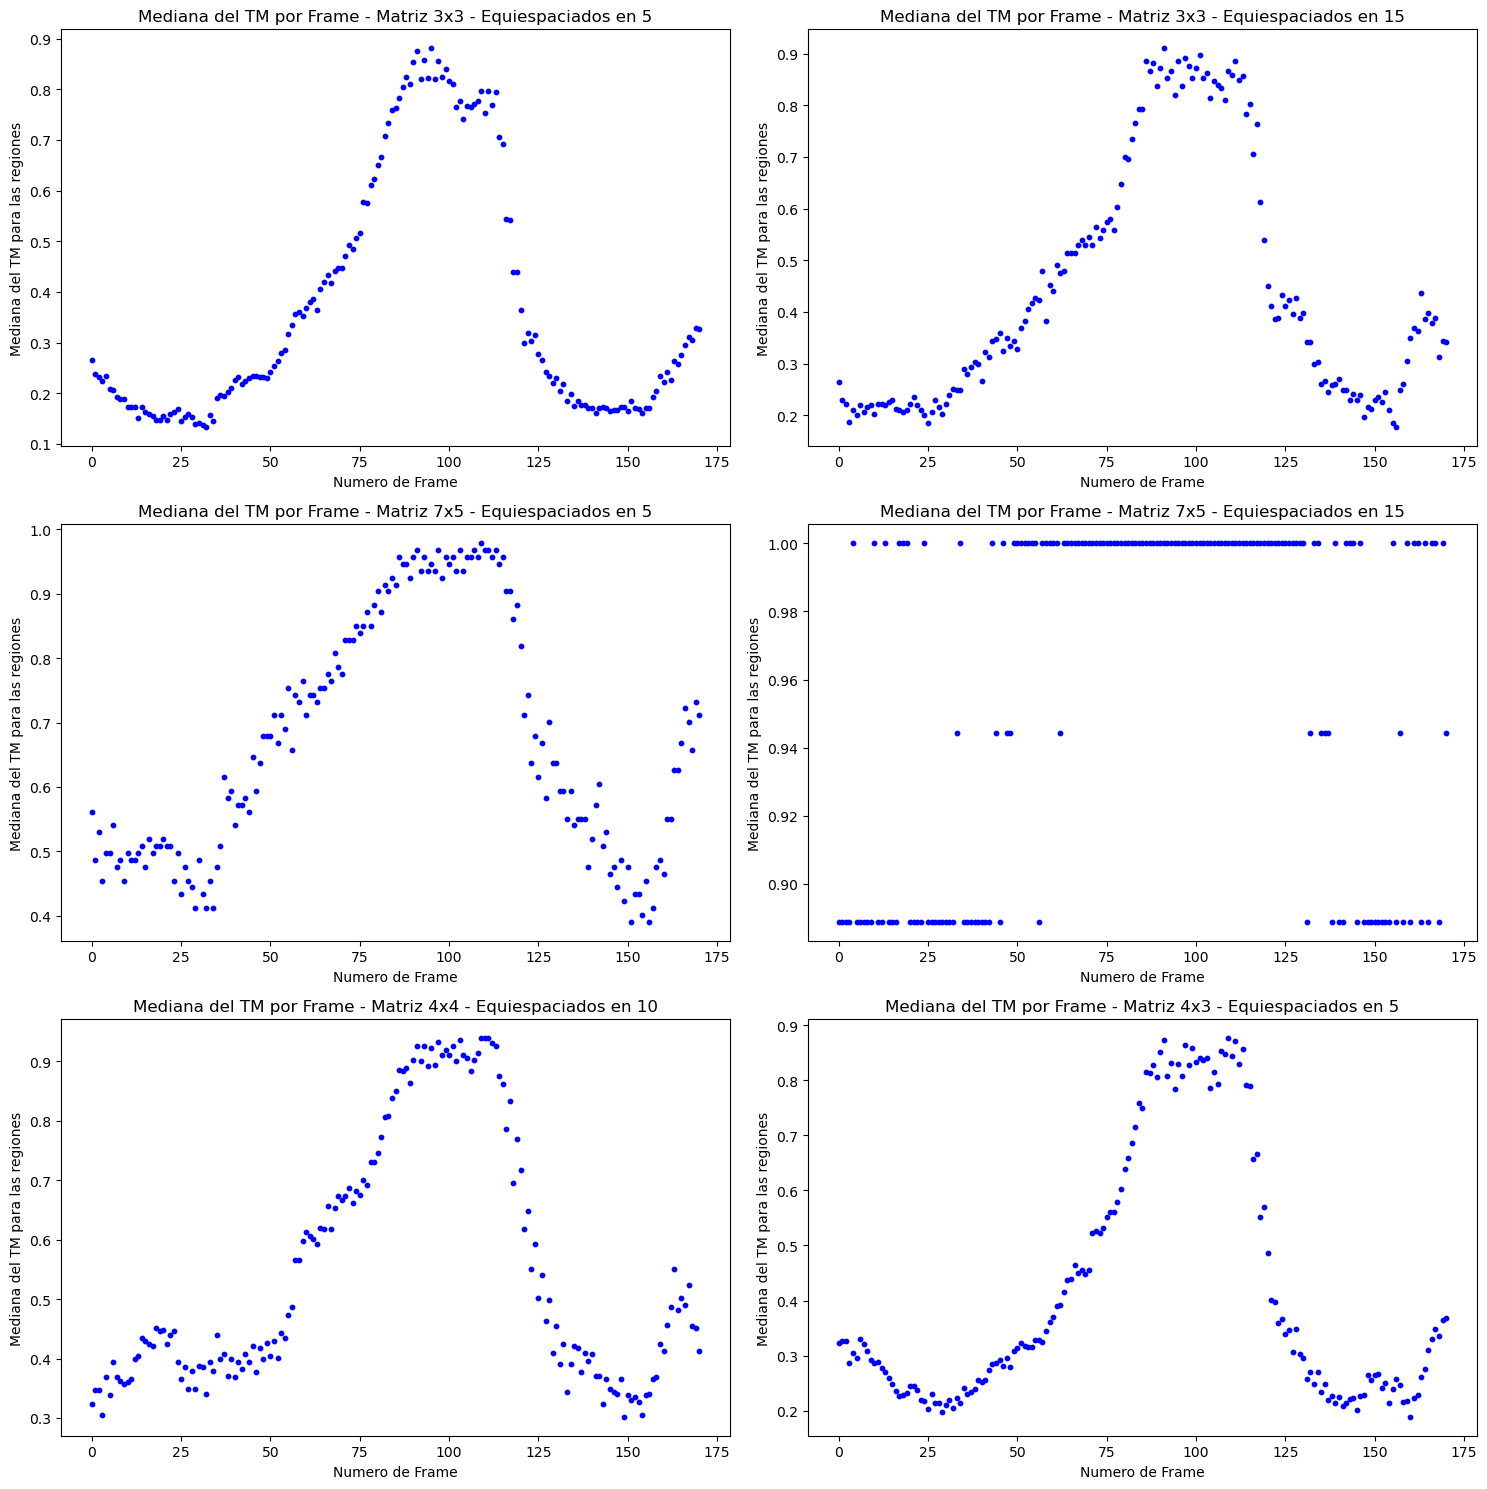

In [109]:
# Configuraciones de la matriz de enfoque
configs = [
    {'N': 3, 'M': 3, 'spacing': 5},
    {'N': 3, 'M': 3, 'spacing': 15},
    {'N': 7, 'M': 5, 'spacing': 5},
    {'N': 7, 'M': 5, 'spacing': 15},
    {'N': 4, 'M': 4, 'spacing': 10},
    {'N': 4, 'M': 3, 'spacing': 5}
]
sharpness_threshold = 0.4 
ratio = 0.05
video_path = 'data/focus_video.mov'

cap = cv.VideoCapture(video_path)

sharpness_values_per_config = {f"N{cfg['N']}M{cfg['M']}S{cfg['spacing']}": [] for cfg in configs}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Obtener la region de interes central
    y_start, y_end, x_start, x_end = get_center_roi_coord(gray, ratio)
    roi = gray[y_start:y_end, x_start:x_end]
    
    for cfg in configs:
        N, M, spacing = cfg['N'], cfg['M'], cfg['spacing']
        # Dividir la ROI en una matriz de N x M regiones con equiespaciado
        regions = get_grid_regions(roi, N, M, spacing)
        
        sharpness_values = []

        for row_regions in regions:
            for region, (x, y, x_end, y_end) in row_regions:
                # Verificar que la región no esté vacía
                if region.size == 0:
                    continue
                sharpness = calculate_sharpness(region) # calcular el FM de cada region
                sharpness_values.append(sharpness)
        key = f"N{N}M{M}S{spacing}"
        sharpness_values_per_config[key].append(sharpness_values)

cap.release()

# Graficar los resultados
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.ravel()

for ax, cfg in zip(axs, configs):
    N, M, spacing = cfg['N'], cfg['M'], cfg['spacing']
    key = f"N{N}M{M}S{spacing}"
    sharpness_values_per_frame = sharpness_values_per_config[key]

    for i, sharpness_values in enumerate(sharpness_values_per_frame):
        ax.scatter(i, np.median(sharpness_values), color='blue', s=10)
    ax.set_title(f"Mediana del TM por Frame - Matriz {N}x{M} - Equiespaciados en {spacing}")
    ax.set_xlabel("Numero de Frame")
    ax.set_ylabel("Mediana del TM para las regiones")

plt.tight_layout()
plt.show()


- Usando la media para graficar:

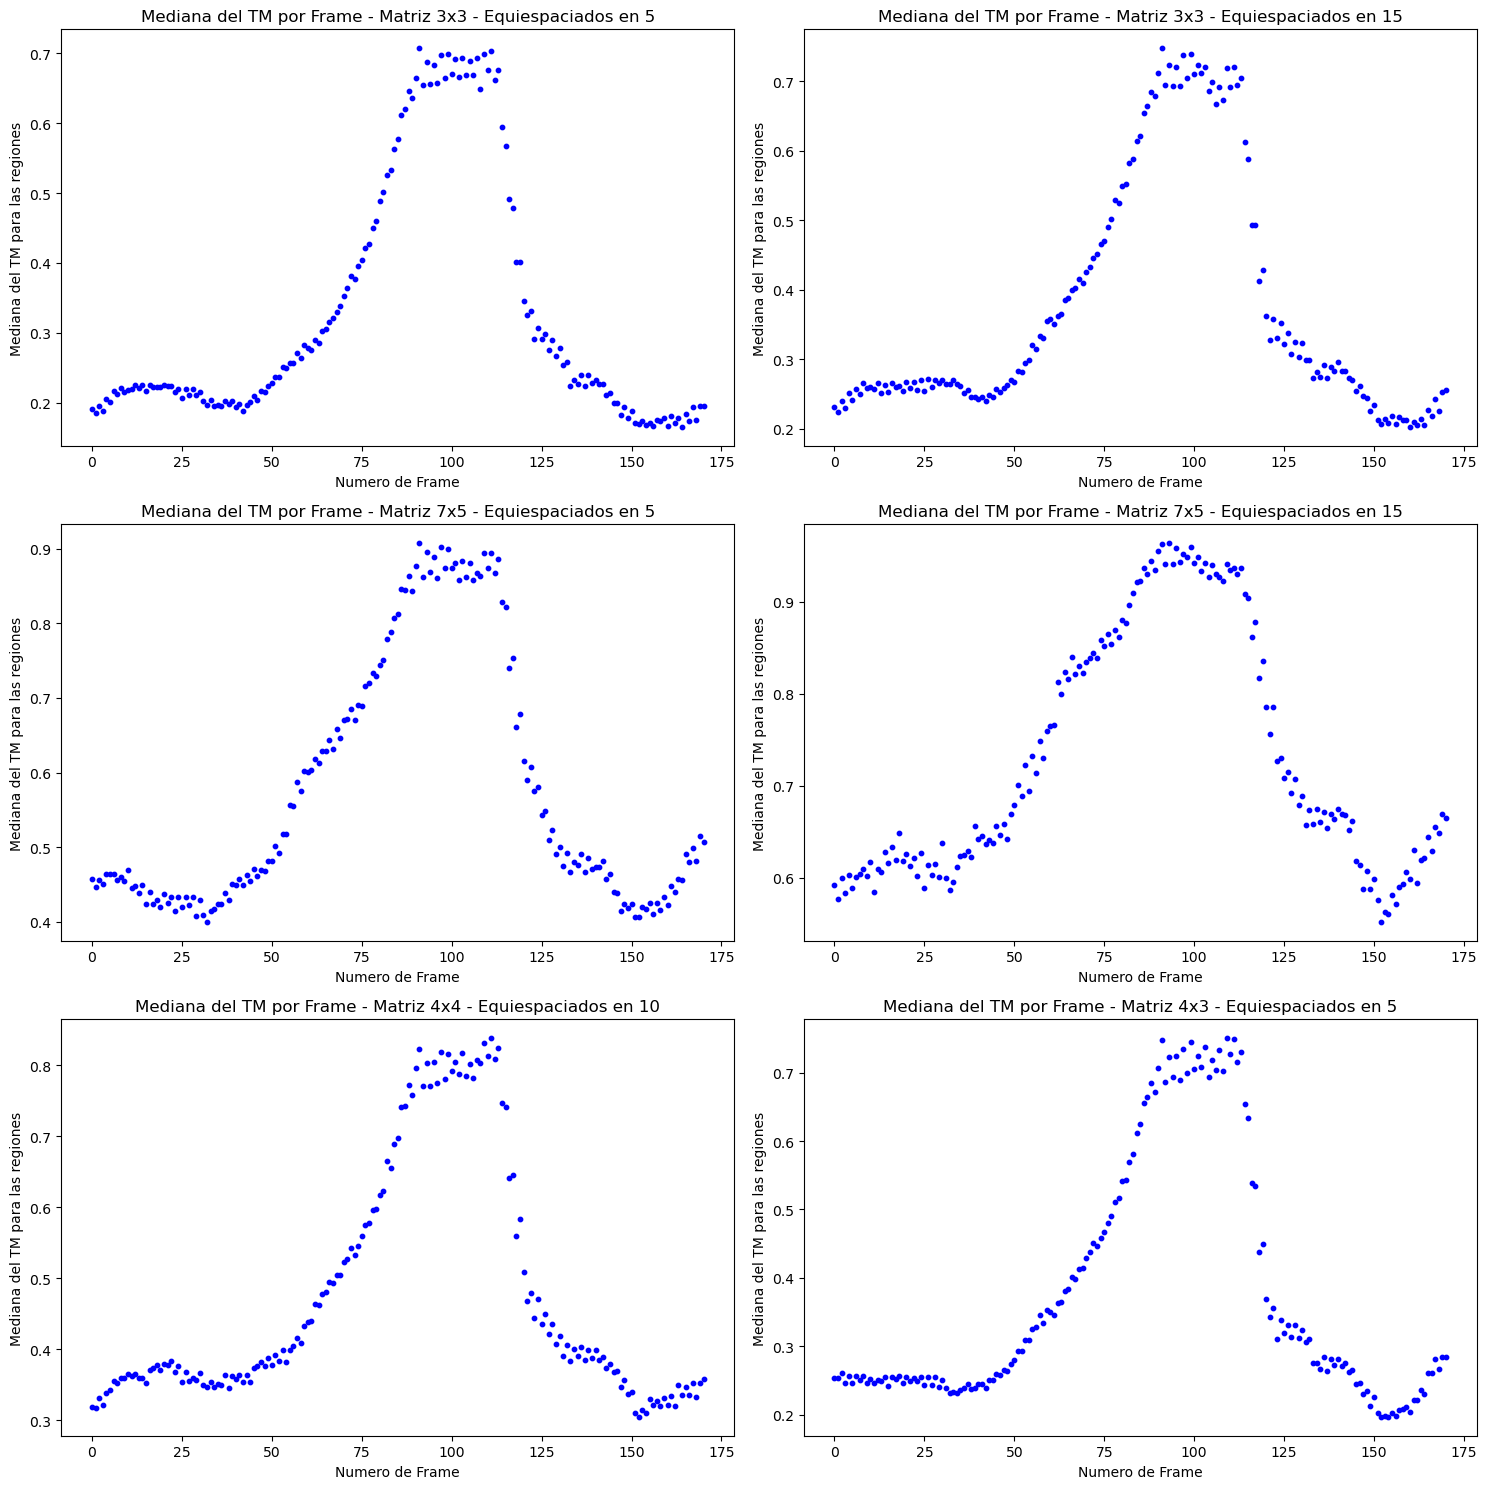

In [108]:
# Configuraciones de la matriz de enfoque
configs = [
    {'N': 3, 'M': 3, 'spacing': 5},
    {'N': 3, 'M': 3, 'spacing': 15},
    {'N': 7, 'M': 5, 'spacing': 5},
    {'N': 7, 'M': 5, 'spacing': 15},
    {'N': 4, 'M': 4, 'spacing': 10},
    {'N': 4, 'M': 3, 'spacing': 5}
]
sharpness_threshold = 0.4 
ratio = 0.1
video_path = 'data/focus_video.mov'

cap = cv.VideoCapture(video_path)

sharpness_values_per_config = {f"N{cfg['N']}M{cfg['M']}S{cfg['spacing']}": [] for cfg in configs}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Obtener la region de interes central
    y_start, y_end, x_start, x_end = get_center_roi_coord(gray, ratio)
    roi = gray[y_start:y_end, x_start:x_end]
    
    for cfg in configs:
        N, M, spacing = cfg['N'], cfg['M'], cfg['spacing']
        # Dividir la ROI en una matriz de N x M regiones con equiespaciado
        regions = get_grid_regions(roi, N, M, spacing)
        
        sharpness_values = []

        for row_regions in regions:
            for region, (x, y, x_end, y_end) in row_regions:
                # Verificar que la región no esté vacía
                if region.size == 0:
                    continue
                sharpness = calculate_sharpness(region) # calcular el FM de cada region
                sharpness_values.append(sharpness)
        key = f"N{N}M{M}S{spacing}"
        sharpness_values_per_config[key].append(sharpness_values)

cap.release()

# Graficar los resultados
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.ravel()

for ax, cfg in zip(axs, configs):
    N, M, spacing = cfg['N'], cfg['M'], cfg['spacing']
    key = f"N{N}M{M}S{spacing}"
    sharpness_values_per_frame = sharpness_values_per_config[key]

    for i, sharpness_values in enumerate(sharpness_values_per_frame):
        ax.scatter(i, np.array(sharpness_values).mean(), color='blue', s=10)
    ax.set_title(f"Mediana del TM por Frame - Matriz {N}x{M} - Equiespaciados en {spacing}")
    ax.set_xlabel("Numero de Frame")
    ax.set_ylabel("Mediana del TM para las regiones")

plt.tight_layout()
plt.show()


- Se observa que utilizando menor **equiespaciado**, se obtienen mayores maximos cuando el video enfoca y menores minimos cuando el video desenfoca. 
- Disminuir el **ROI** (se probó con 0.05) también aumenta el valor de TM. Llegando a "saturar" los máximos (en 1) y mínimos (en 0), lo cual se visualizó con la gráfica de la mediana de la métrica por frame. Es decir que mide el enfoque máximo y mínimo posible en algunos casos.
- Cuando se aumentan los elementos de la matriz, los valores generales de TM aumentan.


#### Video

- Matriz 7x5

In [46]:
output_path = 'output/matriz_enfoque_7x5.avi'

# Configuración de la matriz de enfoque
N, M = 7, 5  
sharpness_threshold = 0.4 
ratio = 0.1  # Proporción de la ROI
equispace = 15

cap = cv.VideoCapture(video_path)
fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter(output_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Obtener la region de interes central
    y_start, y_end, x_start, x_end = get_center_roi_coord(gray, ratio)
    roi = gray[y_start:y_end, x_start:x_end]
    
    # Dividir la ROI en una matriz de N x M regiones con equiespaciado
    regions = get_grid_regions(roi, N, M, equispace)
    
    for row_regions in regions:
        for region, (x, y, x_end, y_end) in row_regions:
            # Verificar que la región no esté vacía
            if region.size == 0:
                continue
            sharpness = calculate_sharpness(region) # calcular el FM de cada region
            color = (0, 255, 0) if sharpness >= sharpness_threshold else (0, 0, 255)
            # Ajustar las coordenadas del rectángulo para el frame completo
            cv.rectangle(frame, (x_start + x, y_start + y), (x_start + x_end, y_start + y_end), color, 1)
    
    out.write(frame)

cap.release()
out.release()
cv.destroyAllWindows()


- Matriz 4x4, variando a su vez el espacio entre elementos.

In [68]:
output_path = 'output/matriz_enfoque_4x4.avi'

# Configuración de la matriz de enfoque
N, M = 4, 4
sharpness_threshold = 0.4 
ratio = 0.1  # Proporción de la ROI
equispace = 10

cap = cv.VideoCapture(video_path)
fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter(output_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Obtener la region de interes central
    y_start, y_end, x_start, x_end = get_center_roi_coord(gray, ratio)
    roi = gray[y_start:y_end, x_start:x_end]
    
    # Dividir la ROI en una matriz de N x M regiones con equiespaciado
    regions = get_grid_regions(roi, N, M, equispace)
    
    for row_regions in regions:
        for region, (x, y, x_end, y_end) in row_regions:
            # Verificar que la región no esté vacía
            if region.size == 0:
                continue
            sharpness = calculate_sharpness(region) # calcular el FM de cada region
            color = (0, 255, 0) if sharpness >= sharpness_threshold else (0, 0, 255)
            # Ajustar las coordenadas del rectángulo para el frame completo
            cv.rectangle(frame, (x_start + x, y_start + y), (x_start + x_end, y_start + y_end), color, 1)
    
    out.write(frame)

cap.release()
out.release()
cv.destroyAllWindows()
